# Build a P-value interpreter function with ChatGPT

In [11]:
def interpret_p_value(p_value, threshold=0.05):
    """
    Interpret the p-value in a statistical context against a specific threshold.

    Parameters:
    p_value (float): The p-value to interpret, expected to be in the range 0 to 1.
    threshold (float): The significance level threshold, default is 0.05.

    Returns:
    None: Prints the interpretation of the p-value.

    Raises:
    ValueError: If the p_value or threshold is not within the range [0, 1].

    Description:
    This function assesses the provided p-value against a given threshold:
    - p < threshold: Evidence suggests rejecting the null hypothesis.
    - p >= threshold: Not enough evidence to reject the null hypothesis.

    It's important to note that the interpretation of p-values is context-dependent
    and should be considered along with other factors in statistical analysis.
    """
    if not (0 <= p_value <= 1):
        raise ValueError("p_value must be between 0 and 1.")
    if not (0 <= threshold <= 1):
        raise ValueError("threshold must be between 0 and 1.")

    if p_value < threshold:
        print(f"p-value ({p_value}) is less than the threshold ({threshold}).")
        print("Evidence suggests rejecting the null hypothesis.")
    else:
        print(f"p-value ({p_value}) is greater than or equal to the threshold ({threshold}).")
        print("Not enough evidence to reject the null hypothesis.")

# Example usage
interpret_p_value(0.03, threshold=0.05)

p-value (0.03) is less than the threshold (0.05).
Evidence suggests rejecting the null hypothesis.


# Libraries and Data

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm

In [13]:
# Load the data
df = pd.read_csv("amazon_landing_page.csv")
df.head()

,user_id,group,landing_page,converted
0,851104,control,old_page,0
1,804228,control,old_page,0
2,661590,treatment,new_page,0
3,853541,treatment,new_page,0
4,864975,control,old_page,1


In [14]:
# df information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   group         294480 non-null  object
 2   landing_page  294480 non-null  object
 3   converted     294480 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.0+ MB


# EDA

In [15]:
# 1. Descriptive Statistics and Data Quality Check
desc_stats = df.describe()
print(desc_stats)
print(f"\nMissing values in each column:\n {df.isnull().sum()}")
print(f"\nNumber of duplicate entries: {df.duplicated().sum()}")

             user_id      converted
count  294480.000000  294480.000000
mean   787973.538896       0.119658
std     91210.917091       0.324562
min    630000.000000       0.000000
25%    709031.750000       0.000000
50%    787932.500000       0.000000
75%    866911.250000       0.000000
max    945999.000000       1.000000

Missing values in each column:
 user_id         0
group           0
landing_page    0
converted       0
dtype: int64

Number of duplicate entries: 2


In [16]:
# Checking consistency between group and landing_page
consistency_check = (df['group'] == 'control') == (df['landing_page'] == 'old_page')
print(f"\nConsistency between group and landing_page:  {consistency_check.all()}")

# where the control group goes into the old page. putting people in the control when they shouldnt be.



Consistency between group and landing_page:  False


In [17]:
# 2. Group Analysis
group_conversion = df.groupby('group')['converted'].mean()
print("\nConversion rate by group:\n", group_conversion)


Conversion rate by group:
 group
control      0.120399
treatment    0.118918
Name: converted, dtype: float64


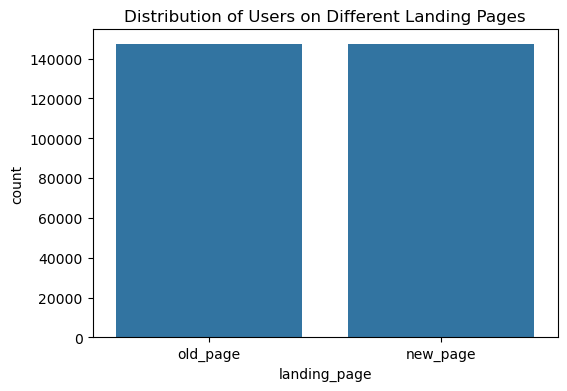

In [18]:
# Distribution of users on different landing pages
plt.figure(figsize=(6, 4))
sns.countplot(x='landing_page', data=df)
plt.title('Distribution of Users on Different Landing Pages')
plt.show()

# Data Preprocessing

In [19]:
# Removing duplicate entries for user_id
df_unique = df.drop_duplicates(subset='user_id')

In [20]:
# Checking for inconsistencies between group and landing_page
inconsistencies = df_unique[((df_unique['group'] == 'control') & (df_unique['landing_page'] != 'old_page')) |
                    ((df_unique['group'] == 'treatment') & (df_unique['landing_page'] != 'new_page'))]

# Counting the number of inconsistencies
num_inconsistencies = inconsistencies.shape[0]
print(f"Number of inconsistencies: {num_inconsistencies}") 


Number of inconsistencies: 2044


In [21]:
# Option 1: Remove the inconsistent rows
df_fixed = df_unique.drop(inconsistencies.index)

# Bayesian A/B Testing

In [8]:
# Import libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [22]:
# Get the total conversions and total observations for each grup
conversions_A = df_fixed[(df_fixed['group'] == 'control') & (df_fixed['converted'] == 1)].shape[0]
conversions_B = df_fixed[(df_fixed['group'] == 'treatment') & (df_fixed['converted'] == 1)].shape[0]
total_A = df_fixed[(df_fixed['group'] == 'control')].shape[0]
total_B = df_fixed[(df_fixed['group'] == 'treatment')].shape[0]

In [23]:
# Define the prior distributions for the conversion rates
# it is uncommon to go above 10
alpha_prior = 1
beta_prior = 10

In [24]:
# Posterior
posterior_A = tfd.Beta(conversions_A + alpha_prior, total_A - conversions_A + beta_prior)
posterior_B = tfd.Beta(conversions_B + alpha_prior, total_B - conversions_B + beta_prior)

In [25]:
# Sampling from the posteriors
num_samples = 10000
samples_A = posterior_A.sample(num_samples)
samples_B = posterior_B.sample(num_samples)

In [26]:
# Calculate the probability that B is better than A
prob_B_better_than_A = tf.reduce_mean(tf.cast(samples_B > samples_A,
                                            dtype = tf.float32))
print(f"Probability that B is better than A is {prob_B_better_than_A.numpy()}")

Probability that B is better than A is 0.0957999974489212


### Proportions test with ChatGPT

**Null Hypothesis**: There is no difference between both groups

**Alternative Hypothesis**: There is a difference in both groups

In [27]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative = "two-sided")
interpret_p_value(p_value, threshold=0.05)

p-value (0.19534709281210638) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


In [28]:
# Proportions Test
import statsmodels.stats.proportion as proportion
z_value, p_value = proportion.proportions_ztest(
    [conversions_A, conversions_B], [total_A, total_B],
    alternative = "larger")
interpret_p_value(p_value, threshold=0.05)

p-value (0.09767354640605319) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


# Sequential Testing and Early Stopping

In [29]:
# Simulate Experiments
n_experiments = 1000 # number of experiments to simulate
n_weeks = 5 # number of weeks each experiment runs
n_per_week = 500 # Number of participants per week in each experiment
cr_control = 0.12
cr_treatment = 0.11

In [30]:
# Running the simulations
early_stopping_results = []

# simulate for each experiment
for _ in range(n_experiments):
  # simulate data
  control_group = np.random.binomial(1,
                                    cr_control,
                                    n_per_week * n_weeks)
  treatment_group = np.random.binomial(1,
                                    cr_control,
                                    n_per_week * n_weeks)

  # sequentially analyze each week
  for week in range(1, n_weeks + 1):
    # Slide the data up to n week
    control_data = control_group[:week * n_per_week]
    treatment_data = treatment_group[:week * n_per_week]

    # Prepare data for proportions test  and perform the test
    z_value, p_value = proportion.proportions_ztest(
        [control_data.sum(), treatment_data.sum()],
        [len(control_data), len(treatment_data)])

    #check if result is significant
    if p_value < 0.05:
      early_stopping_results.append((week, p_value))
      break
  else:
    #record the results
    early_stopping_results.append((n_weeks, p_value))

In [31]:
# Check the results
early_stopping_results

[(5, 0.2006249929342495),
 (2, 0.0375837133156295),
 (1, 0.02364532722953858),
 (5, 0.7292133982344915),
 (5, 0.09446355044850159),
 (5, 0.75912253885715),
 (5, 0.7634207153407159),
 (5, 0.5417616928836827),
 (5, 0.5457816153042844),
 (5, 0.16912962081592864),
 (5, 0.729581087680399),
 (5, 0.6967436916347254),
 (5, 0.6343238871381908),
 (5, 0.23896750781126774),
 (5, 0.9303394761731107),
 (1, 0.02310557315184375),
 (3, 0.037866676687017584),
 (5, 0.8318249294470511),
 (5, 0.38612842988976104),
 (5, 0.8951413265637497),
 (5, 0.6708298422645234),
 (5, 0.8961990136379341),
 (5, 0.4379839265913843),
 (5, 0.8928999793406239),
 (5, 0.23134516946575767),
 (5, 0.6066142373795594),
 (5, 0.8977835368985686),
 (3, 0.048434046666123644),
 (1, 0.028594043916804295),
 (5, 0.7341952455648763),
 (5, 0.2065990520918639),
 (1, 0.013855363331300333),
 (3, 0.018058971105001397),
 (5, 0.15256242090501193),
 (5, 0.294696211578239),
 (5, 0.3638471999686933),
 (1, 0.04994378118367679),
 (5, 0.1307129479798513

In [32]:
# Analyze the results
stopped_weeks, stopped_p_values = zip(*early_stopping_results)
average_stopping_week = np.mean(stopped_weeks)
print(f"The Average Stopping week is {average_stopping_week}")

The Average Stopping week is 4.61


# A/B/C Tests


In [33]:
# Load the data
df_netflix = pd.read_csv("netflix_wednesday_thumbnail.csv")
df_netflix.head(10)

,Participant ID,Thumbnail Variant,Watched Show,Minutes Watched
0,1,Thumbnail A,True,25
1,2,Thumbnail B,False,0
2,3,Thumbnail A,False,0
3,4,Thumbnail B,False,0
4,5,Thumbnail B,True,46
5,6,Thumbnail C,True,1
6,7,Thumbnail A,False,0
7,8,Thumbnail C,False,0
8,9,Thumbnail A,True,15
9,10,Thumbnail A,False,0


In [34]:
# 1. Descriptive Statistics
df_netflix.describe()

#if standard deviation is bigger than mean you have a very diverse data set with alot of variability 

,Participant ID,Minutes Watched
count,20000.000000,20000.000000
mean,10000.500000,15.179150
std,5773.647028,19.285418
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,1.000000
75%,15000.250000,31.000000
max,20000.000000,59.000000


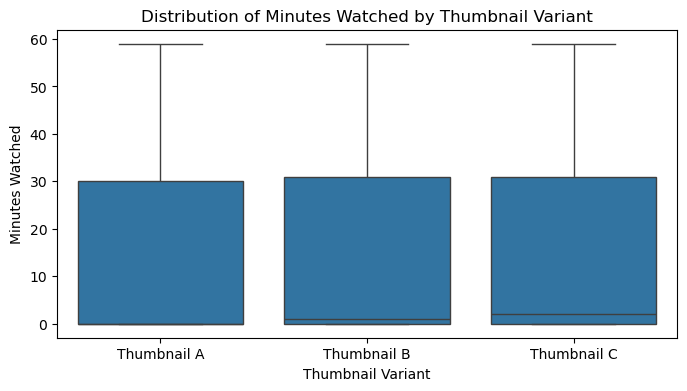

In [35]:
# 2. Distribution Analysis
plt.figure(figsize=(8, 4))
sns.boxplot(x='Thumbnail Variant', y='Minutes Watched', data=df_netflix)
plt.title('Distribution of Minutes Watched by Thumbnail Variant')
plt.show()

In [36]:
# 3. Watched Show Proportion by Thumbnail Variant
watched_show_proportion = df_netflix.groupby('Thumbnail Variant')['Watched Show'].mean()
print(watched_show_proportion)

Thumbnail Variant
Thumbnail A    0.494050
Thumbnail B    0.503876
Thumbnail C    0.508342
Name: Watched Show, dtype: float64


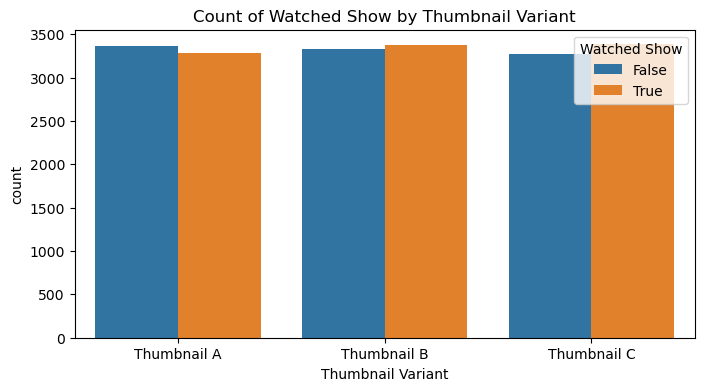

In [37]:
# 5. Visualization of Watched Show and Thumbnail Variant
plt.figure(figsize=(8, 4))
sns.countplot(x='Thumbnail Variant', hue='Watched Show', data=df_netflix)
plt.title('Count of Watched Show by Thumbnail Variant')
plt.show()

Thumbnail C has highest participants. C has the highest median as well. We dont have that many outliers since there are no stars in the box plot

### Chi Square Test with ChatGPT

Null Hypothesis: There is no relationship between the thumbnails and people watching the show

Alternative Hypothesis: There is a relationship between the thumbnails and people watching the show

In [39]:
# Creating a contingency table
contingency = pd.crosstab(df_netflix['Thumbnail Variant'], df_netflix['Watched Show'])

# Performing the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print(contingency)
interpret_p_value(p, threshold=0.05)

Watched Show       False  True 
Thumbnail Variant              
Thumbnail A         3359   3280
Thumbnail B         3328   3380
Thumbnail C         3271   3382
p-value (0.24143033666177097) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


If the outcome would be statistically significant, you would perform the Bonferroni method

### Bonferroni Method

In [40]:
from itertools import combinations

In [41]:
# Get all unique combinations for pairwise comparison
combinations = list(combinations(df_netflix['Thumbnail Variant'].unique(), 2))

combinations

[('Thumbnail A', 'Thumbnail B'),
 ('Thumbnail A', 'Thumbnail C'),
 ('Thumbnail B', 'Thumbnail C')]

In [42]:
# Bonferroni method adjustment
adjusted_alpha = 0.05 / len(combinations)
significant_pairs = []

for combo in combinations:
  # Creating a contingency table
  contingency = pd.crosstab(
      df_netflix[df_netflix['Thumbnail Variant'].isin(combo)]['Thumbnail Variant'],
      df_netflix['Watched Show'])

  # Performing the chi-square test
  chi2, p, dof, expected = stats.chi2_contingency(contingency)

  if p < adjusted_alpha:
    significant_pairs.append((combo,p))

print(f"Significant pairs after the Bonferroni adjustment: {significant_pairs}")

Significant pairs after the Bonferroni adjustment: []


### ANOVA Test

Null Hypothesis: There is no difference between the variants

Alternative: There are differences between the groups

In [45]:
# Create groups
group_a = df_netflix[df_netflix['Thumbnail Variant'] == 'Thumbnail A']['Minutes Watched']
group_b = df_netflix[df_netflix['Thumbnail Variant'] == 'Thumbnail B']['Minutes Watched']
group_c = df_netflix[df_netflix['Thumbnail Variant'] == 'Thumbnail C']['Minutes Watched']

print(group_a, group_b, group_c)

0        25
2         0
6         0
8        15
9         0
         ..
19985    27
19993    21
19994     0
19998    49
19999     0
Name: Minutes Watched, Length: 6639, dtype: int64 1         0
3         0
4        46
12        0
16        0
         ..
19988    14
19989     0
19991    42
19996    57
19997    52
Name: Minutes Watched, Length: 6708, dtype: int64 5         1
7         0
11        0
13        1
14       37
         ..
19977    16
19983    29
19990     0
19992     0
19995     0
Name: Minutes Watched, Length: 6653, dtype: int64


In [44]:
# Perform the ANOVA test
F, p_value = stats.f_oneway(group_a,group_b, group_c)
interpret_p_value(p_value, threshold=0.05)

p-value (0.5770534842828645) is greater than or equal to the threshold (0.05).
Not enough evidence to reject the null hypothesis.


### Hukey's HSD

In [46]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [47]:
# Perform the Tukey's HSD test
tukey = pairwise_tukeyhsd(endog = df_netflix['Minutes Watched'],
                        groups = df_netflix['Thumbnail Variant'],
                        alpha = 0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
Thumbnail A Thumbnail B   0.3454 0.5551 -0.4372 1.1279  False
Thumbnail A Thumbnail C   0.2234 0.7823 -0.5608 1.0075  False
Thumbnail B Thumbnail C   -0.122  0.929 -0.9041 0.6602  False
-------------------------------------------------------------
